# InsightFace for RGB Data

In [1]:
import insightface
from insightface.app.common import Face
from insightface.model_zoo import model_zoo
import os
# REQUIRED FOR CUDA TO BE USED
import torch

num_subjects = 19
BASE_DIR = os.getcwd()

det_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "det_10g.onnx")
rec_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "w600k_r50.onnx")

det_model = model_zoo.get_model(det_model_path)
rec_model = model_zoo.get_model(rec_model_path)

det_model.prepare(ctx_id=0, input_size=(480, 640), det_thres=0.5)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo',

## Embedding

In [4]:
from glob import glob
import numpy as np
from tqdm import tqdm
from utils import by_experiment
import json

def process_images(path, subjects=[0]):
    undetected = []

    for subject in subjects:
        embs_subject_path = f"data/InsightFace_embs/embs_{subject}.npy"
        if not os.path.exists(embs_subject_path):
            subject_embeddings = []
            print(f"Subject: {subject}")

            for img_path in tqdm(sorted(glob(rf"{path}\{subject}\*_colour.npy"), key=by_experiment)):
                for i, img in enumerate(np.load(img_path).astype(np.float32)):
                    # Reformat to BGR for OpenCV
                    img = img[..., ::-1]
                    bboxes, kpss = det_model.detect(img, max_num=0, metric="default")
                    # If no face detected, log and add dummy embedding with np.infs
                    if len(bboxes) != 1:
                        undetected.append((img_path.split('\\')[-1], i))
                        subject_embeddings.append(np.zeros((512)) + np.inf)
                        continue
                    face = Face(bbox=bboxes[0, :4], kps=kpss[0], det_score=bboxes[0, 4])
                    rec_model.get(img, face)
                    subject_embeddings.append(face.normed_embedding)

            subject_embeddings = np.stack(subject_embeddings, axis=0)
            print(subject_embeddings.shape)
            np.save(embs_subject_path, subject_embeddings)
    
    if len(undetected) > 0:
        with open('data/InsightFace_embs/undetected.json', 'w', encoding='utf-8') as f:
            json.dump(undetected, f, ensure_ascii=False, indent=4)

def load_embeddings(path, subjects=[0]):
    labels, unseen_labels = [], []
    embeddings, unseen_embeddings = [], []
    for subject in subjects:
        embs_path = f"{path}/embs_{subject}.npy"
        if os.path.exists(embs_path):
            subject_embeddings = np.load(embs_path)
            h = len(subject_embeddings)//2
            embeddings.append(subject_embeddings[:h])
            unseen_embeddings.append(subject_embeddings[h:])
            labels += [subject]*len(subject_embeddings[:h])
            unseen_labels += [subject]*len(subject_embeddings[h:])

    embeddings = np.concatenate(embeddings, axis=0)
    unseen_embeddings = np.concatenate(unseen_embeddings, axis=0)

    print(embeddings.shape)
    print(unseen_embeddings.shape)
    print(len(labels))
    print(len(unseen_labels))
    return labels, embeddings, unseen_labels, unseen_embeddings

DATA_DIR = os.path.relpath(f"../../Soli/soli_realsense/data")
subjects = range(num_subjects)
process_images(DATA_DIR, subjects)
labels, embeddings, unseen_labels, unseen_embeddings = load_embeddings("data/RGB", subjects)

Subject: 2


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

(150, 512)
(1200, 512)
(1200, 512)
1200
1200


## Prediction

In [5]:
from collections import defaultdict

def search_flatten(embeddings, labels, unseen_embeddings, threshold=0.5):
    pred_names = []
    for emb in unseen_embeddings:
        scores = np.dot(emb, embeddings.T)
        scores = np.clip(scores, 0., 1.)

        idx = np.argmax(scores)
        if scores[idx] > threshold:
            pred_names.append(labels[idx])
        else:
            pred_names.append(None)
    
    return pred_names

def get_averages(labels, scores):
    d = defaultdict(list)
    for l, s in zip(labels, scores):
        d[l].append(s)
    
    return {n:np.mean(s) for n, s in d.items()}

def search_average(embeddings, labels, unseen_embeddings, threshold=0.5):
    pred_names = []
    for emb in unseen_embeddings:
        scores = np.dot(emb, embeddings.T)
        scores = np.clip(scores, 0., 1.)

        averages = get_averages(labels, scores)
        pred = sorted(averages, key=lambda x: averages[x], reverse=True)[0]

        if averages[pred] > threshold:
            pred_names.append(pred)
        else:
            pred_names.append(None)
    
    return pred_names

## Evaluation

In [6]:
from sklearn.metrics import confusion_matrix

def evaluate(true_labels, pred_labels, classes):
    coverage = np.mean([n is not None for n in pred_labels]) * 100.

    is_corrects = [t == p for t, p in zip(true_labels, pred_labels) if p]
    if not is_corrects:
        is_corrects.append(False)

    accuracy = np.mean(is_corrects) * 100.

    prec_cm = confusion_matrix(true_labels, pred_labels)

    return accuracy, coverage, prec_cm

### Accuracy and Coverage

In [7]:
import pandas as pd

pred_names = search_flatten(embeddings, labels, unseen_embeddings, threshold=0)
acc_flatten, cov_flatten = evaluate(unseen_labels, pred_names)

pred_names = search_average(embeddings, labels, unseen_embeddings, threshold=0)
acc_average, cov_average = evaluate(unseen_labels, pred_names)

# TODO: ALSO ACCOUNT FOR FAILURES -> UNDETECTED FACES ETC.
results = pd.DataFrame([
    {'method': 'flatten', 'accuracy': acc_flatten, 'coverage': cov_flatten},
    {'method': 'average', 'accuracy': acc_average, 'coverage': cov_average},
])

results

,method,accuracy,coverage
0,flatten,100.0,98.333333
1,average,100.0,95.583333


# Analysing Best Threshold

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.arange(0, 1, 0.05)
accuracies = []
coverages = []
for t in thresholds:
    # BEST PERFORMING IS FLATTEN
    pred_names = search_flatten(embeddings, labels, unseen_embeddings, t)
    # pred_names = search_average(known_embeddings, known_names, unknown_embeddings, t)
    acc, cov = evaluate(unseen_labels, pred_names)
    accuracies.append(acc)
    coverages.append(cov)

plt.plot(thresholds, accuracies)
plt.plot(thresholds, coverages)
plt.show()

# InsightFace Classifiers

### Load Models and Dataset

In [18]:
import insightface
from insightface.app.common import Face
from insightface.model_zoo import model_zoo
from tqdm import tqdm
import os
# REQUIRED FOR CUDA TO BE USED
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
BASE_DIR = os.getcwd()

det_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "det_10g.onnx")
rec_model_path = os.path.join(BASE_DIR, "../models", "buffalo_l", "w600k_r50.onnx")

det_model = model_zoo.get_model(det_model_path)
rec_model = model_zoo.get_model(rec_model_path)

det_model.prepare(ctx_id=0, input_size=(480, 640), det_thres=0.5)

cuda
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'cudnn_conv_use_max_workspace': '1', 'cudnn_conv1d_pad_to_nc1d': '0', 'tunable_op_enable': '0', 'tunable_op_tuning_enable': '0', 'enable_skip_layer_norm_strict_mode': '0'}, 'CPUExecutionProvider': {}}
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CUDAExecutionProvider': {'do_copy_in_default_stream': '1', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'device_id': '0', 'gpu_external_alloc': '0', 'enable_cuda_graph': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'arena_extend_strategy': 'kNextPowerOf

In [19]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dataset_builder import GenericDataset
import numpy as np
from utils import by_experiment
from glob import glob
import json

def process_rgb(raw_path, subjects, name, num_experiments=15):
    experiments = np.full((len(subjects), num_experiments, 10, 512), np.nan)
    undetected = []

    for sub, subject in enumerate(tqdm(subjects)):
        for img_path in sorted(glob(rf"{raw_path}\{subject}\*_colour.npy"), key=by_experiment):
            exp = by_experiment(img_path)
            experiment_embs = np.full((10, 512), np.nan)
            for frame, img in enumerate(np.load(img_path).astype(np.float32)):
                # Reformat to BGR for OpenCV
                img = img[..., ::-1]
                bboxes, kpss = det_model.detect(img, max_num=0, metric="default")
                if len(bboxes) != 1:
                    undetected.append((img_path.split('\\')[-1], frame))
                    continue
                face = Face(bbox=bboxes[0, :4], kps=kpss[0], det_score=bboxes[0, 4])
                rec_model.get(img, face)
                experiment_embs[frame] = face.normed_embedding
            
            experiments[sub, exp] = np.array(experiment_embs)
    
    np.save(f"data/InsightFace_embs/{name}_insightface_embs.npy", np.array(experiments))
    print(np.array(experiments).shape)
    
    if len(undetected) > 0:
        with open('data/InsightFace_embs/undetected.json', 'a', encoding='utf-8') as f:
            json.dump(undetected, f, ensure_ascii=False, indent=4)

def load_rgb_embs(raw_path, subjects, batch_size=64, train_split=0.6, test_split=0.2, device="cuda", seed=333):
    np.random.seed(seed)
    if not os.path.exists("data/InsightFace_embs/real_insightface_embs.npy"):
        process_rgb(raw_path, subjects, name="real")
        process_rgb(raw_path, [f"9{s}" for s in subjects], name="fake")

    # Subjects x Experiments x Frames x Embedding_Size
    real_dataset = np.load("data/InsightFace_embs/real_insightface_embs.npy")[:, [0, 5, 10]]
    fake_dataset = np.load("data/InsightFace_embs/fake_insightface_embs.npy")[:, [0, 5, 10]]

    print(real_dataset.shape, fake_dataset.shape)

    train, val, test = [], [], []
    train_fake, val_fake, test_fake = [], [], []
    val_split_end = train_split + test_split

    print(real_dataset.shape)
    for subject in real_dataset:
        for experiment in subject:
            filtered = experiment[~np.isnan(experiment).any(axis=1)]
            np.random.shuffle(filtered)
            train.append(filtered[:int(train_split*len(filtered))])
            val.append(filtered[int(train_split*len(filtered)):int(val_split_end*len(filtered))])
            test.append(filtered[int(val_split_end*len(filtered)):])

    for subject in fake_dataset:
        for experiment in subject:
            filtered = experiment[~np.isnan(experiment).any(axis=1)]
            np.random.shuffle(filtered)
            train_fake.append(filtered[:int(train_split*len(filtered))])
            val_fake.append(filtered[int(train_split*len(filtered)):int(val_split_end*len(filtered))])
            test_fake.append(filtered[int(val_split_end*len(filtered)):])

    train = np.concatenate(train)
    train_fake = np.concatenate(train_fake)
    val = np.concatenate(val)
    val_fake = np.concatenate(val_fake)
    test = np.concatenate(test)
    test_fake = np.concatenate(test_fake)

    train_labels = torch.tensor([0]*len(train) + [1]*len(train_fake), device=device, dtype=torch.int64)
    val_labels = torch.tensor([0]*len(val) + [1]*len(val_fake), device=device, dtype=torch.int64)
    test_labels = torch.tensor([0]*len(test) + [1]*len(test_fake), device=device, dtype=torch.int64)

    print(len(train), len(train_fake))
    print(len(val), len(val_fake))
    print(len(test), len(test_fake))
    print()

    train = torch.tensor(np.concatenate((train, train_fake)), device=device, dtype=torch.float32)
    val = torch.tensor(np.concatenate((val, val_fake)), device=device, dtype=torch.float32)
    test = torch.tensor(np.concatenate((test, test_fake)), device=device, dtype=torch.float32)

    print(f"Train: {train.shape}")
    print(f"Validation: {val.shape}")
    print(f"Test: {test.shape}")
    print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")

    train_dataset = GenericDataset(train, train_labels, "train")
    val_dataset = GenericDataset(val, val_labels, "validation")
    test_dataset = GenericDataset(test, test_labels, "test")

    train_loader = DataLoader(train_dataset, batch_size, sampler=SubsetRandomSampler(np.random.permutation(len(train_dataset))))
    val_loader = DataLoader(val_dataset, batch_size, sampler=SubsetRandomSampler(np.random.permutation(len(val_dataset))))
    test_loader = DataLoader(test_dataset, batch_size, sampler=SubsetRandomSampler(np.random.permutation(len(test_dataset))))

    return train_loader, val_loader, test_loader

    
num_subjects = 21
    
torch.cuda.empty_cache()
train, validation, test = load_rgb_embs(os.path.relpath("../../Soli/soli_realsense/data"), range(num_subjects), batch_size=128, device=device)

100%|██████████| 21/21 [02:03<00:00,  5.89s/it]


(21, 15, 10, 512)


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


(21, 15, 10, 512)
(21, 3, 10, 512) (21, 3, 10, 512)
(21, 3, 10, 512)
372 126
124 42
124 42

Train: torch.Size([498, 512])
Validation: torch.Size([166, 512])
Test: torch.Size([166, 512])
Allocated: 0.00 GB


In [6]:
from neural_nets import InsightFaceClassifier
from torch import nn
from utils import load_model, load_history

num_epochs = 20
learning_rate = 0.01

# model = InsightFaceClassifier(num_subjects).to(device)
# Liveness Classifier
model = InsightFaceClassifier(2).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"insightface-liveness_classifier.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]:.4f}\n\tValidation Accuracy: {val_acc[-1]:.4f}")

[Errno 2] No such file or directory: 'models/insightface-liveness_classifier.pt'


### Training

In [7]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc, total = 0., 0., 0.

    for data, labels in tqdm(train):
        # Forward Pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total += labels.size(0)
        running_acc += (predicted == labels).sum().item()

        del data, labels, outputs
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc = 100*running_acc/total
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy: {avg_train_acc:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [avg_train_acc],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in validation:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del data, labels, outputs
        
        avg_val_acc = 100*correct/total
        print(f"\tValidation Accuracy: {avg_val_acc:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append(avg_val_acc)
    torch.save(model_checkpoint, f"models/{model_name}")


Epoch [0/19]:


100%|██████████| 6/6 [00:00<00:00, 182.30it/s]


	Average Train Loss: 0.5845
	Train Accuracy: 81.3333%
	Validation Accuracy: 83.2000%

Epoch [1/19]:


100%|██████████| 6/6 [00:00<00:00, 204.56it/s]


	Average Train Loss: 0.4333
	Train Accuracy: 86.0000%
	Validation Accuracy: 66.4000%

Epoch [2/19]:


100%|██████████| 6/6 [00:00<00:00, 240.63it/s]


	Average Train Loss: 0.3095
	Train Accuracy: 87.8667%
	Validation Accuracy: 96.0000%

Epoch [3/19]:


100%|██████████| 6/6 [00:00<00:00, 260.38it/s]


	Average Train Loss: 0.2077
	Train Accuracy: 95.3333%
	Validation Accuracy: 80.0000%

Epoch [4/19]:


100%|██████████| 6/6 [00:00<00:00, 201.50it/s]


	Average Train Loss: 0.1470
	Train Accuracy: 97.0667%
	Validation Accuracy: 100.0000%

Epoch [5/19]:


100%|██████████| 6/6 [00:00<00:00, 222.80it/s]


	Average Train Loss: 0.1183
	Train Accuracy: 98.8000%
	Validation Accuracy: 98.0000%

Epoch [6/19]:


100%|██████████| 6/6 [00:00<00:00, 214.84it/s]


	Average Train Loss: 0.0956
	Train Accuracy: 99.8667%
	Validation Accuracy: 100.0000%

Epoch [7/19]:


100%|██████████| 6/6 [00:00<00:00, 246.06it/s]


	Average Train Loss: 0.0856
	Train Accuracy: 99.3333%
	Validation Accuracy: 100.0000%

Epoch [8/19]:


100%|██████████| 6/6 [00:00<00:00, 234.24it/s]


	Average Train Loss: 0.0692
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [9/19]:


100%|██████████| 6/6 [00:00<00:00, 208.14it/s]

	Average Train Loss: 0.0615
	Train Accuracy: 100.0000%


	Validation Accuracy: 100.0000%

Epoch [10/19]:


100%|██████████| 6/6 [00:00<00:00, 222.81it/s]


	Average Train Loss: 0.0555
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [11/19]:


100%|██████████| 6/6 [00:00<00:00, 214.87it/s]


	Average Train Loss: 0.0497
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [12/19]:


100%|██████████| 6/6 [00:00<00:00, 227.72it/s]


	Average Train Loss: 0.0464
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [13/19]:


100%|██████████| 6/6 [00:00<00:00, 251.29it/s]


	Average Train Loss: 0.0433
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [14/19]:


100%|██████████| 6/6 [00:00<00:00, 256.95it/s]


	Average Train Loss: 0.0408
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [15/19]:


100%|██████████| 6/6 [00:00<00:00, 139.91it/s]


	Average Train Loss: 0.0385
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [16/19]:


100%|██████████| 6/6 [00:00<00:00, 128.00it/s]


	Average Train Loss: 0.0457
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [17/19]:


100%|██████████| 6/6 [00:00<00:00, 117.97it/s]


	Average Train Loss: 0.0338
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [18/19]:


100%|██████████| 6/6 [00:00<00:00, 146.75it/s]


	Average Train Loss: 0.0333
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%

Epoch [19/19]:


100%|██████████| 6/6 [00:00<00:00, 167.12it/s]

	Average Train Loss: 0.0330
	Train Accuracy: 100.0000%
	Validation Accuracy: 100.0000%


### Testing and Evaluation

In [8]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.data.cpu().numpy())
        del data, labels, outputs
    
    print(f"Test Accuracy of mmFace: {100*correct/total:.4f}%")

Test Accuracy of mmFace: 100.0000%


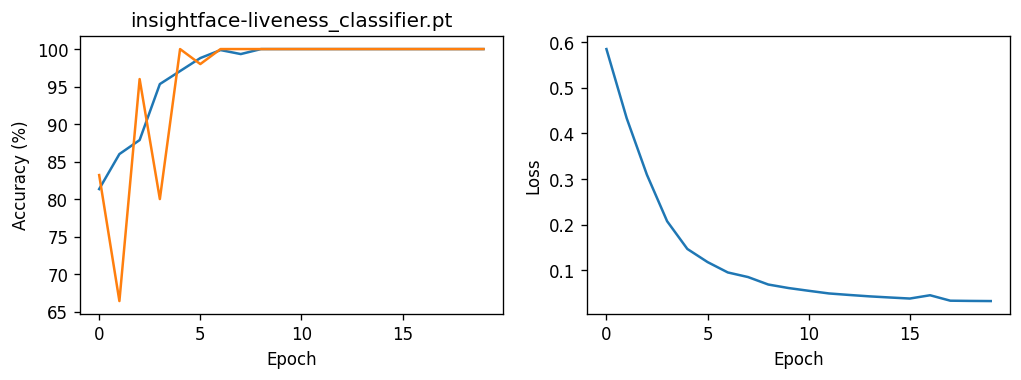

In [9]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

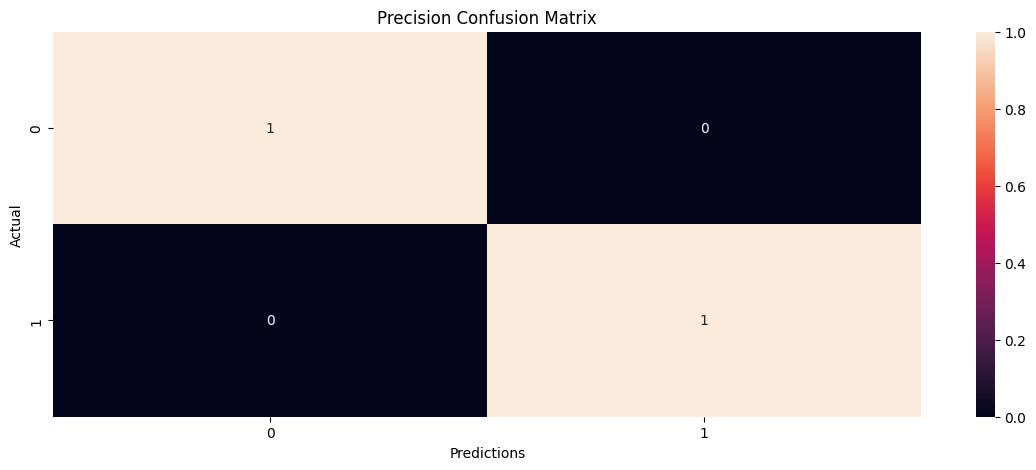

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subjects = range(2)
# subject_names = np.array(anon_names)[subjects]

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subjects, columns=subjects)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')